<a href="https://colab.research.google.com/github/satou409/SIGNATE-.ipynb/blob/main/SIGNATE%E3%81%8A%E5%BC%81%E5%BD%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
# ファイル読み込み
train = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/sample.csv',header=None)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train["t"] = 1
test["t"] = 0
dat = pd.concat([train,test],sort=True).reset_index(drop=True)

In [3]:
dat.index = pd.to_datetime(dat["datetime"])
dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

In [4]:
import numpy as np

dat["days"] = dat.index
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(float)
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
cols = ["precipitation","weather","days","fun","curry","y"]

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [6]:
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=777)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    pred_sub = y_train - pred
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    return model1, model2

In [7]:
kf = KFold(n_splits=5,random_state=777, shuffle=True) # Set shuffle=True
tr = dat[dat["t"]==1][cols]

In [8]:
trains ,tests = [] , []
for train_index, test_index in kf.split(tr):
    tr.loc[train_index,"tt"] = 1
    tr.loc[test_index,"tt"] = 0
    tr["tt"] = tr["tt"].astype(int)
    tmp = pd.get_dummies(tr)

    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]

    model1, model2 = learning(trainX, y_train)

    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])

    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

TRAIN: 7.878691946699353 VARIDATE 10.756255997126631
TRAIN: 7.934279650168929 VARIDATE 10.226259072591304
TRAIN: 8.223365349030384 VARIDATE 7.654816188613056
TRAIN: 7.262769357987639 VARIDATE 13.826314671505262
TRAIN: 8.167632911501304 VARIDATE 9.619186475024971
AVG
7.893347843077523 10.416566480972245


In [9]:
cols = ["precipitation","weather","days","fun","curry","y","t"]
tmp = pd.get_dummies(dat[cols])
trainX = tmp[tmp["t"]==1]
del trainX["t"]
testX = tmp[tmp["t"]==0]
del testX["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

RMSE 7.986229908417227


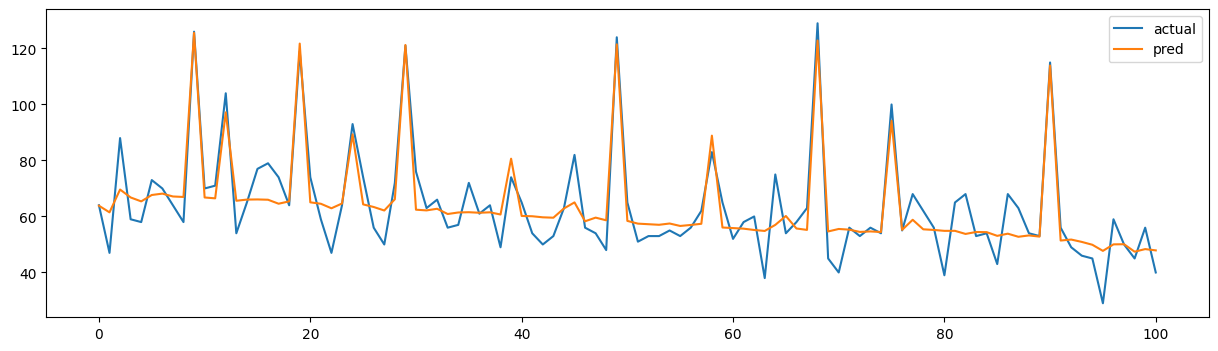

In [10]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred)**0.5)

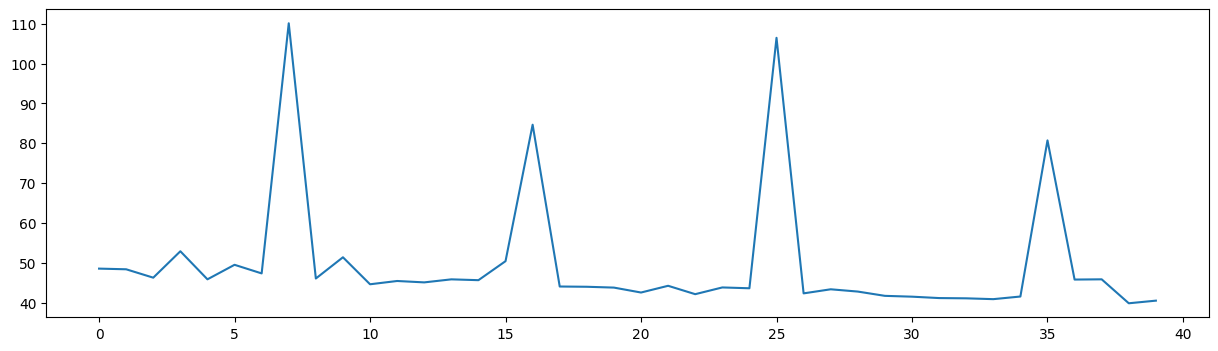

In [11]:
import matplotlib.pyplot as plt # Import matplotlib.pyplot

model1, model2 = learning(trainX,y_train)
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred)